## Learning a classifier

On commence par la fonction de base apprise de la librairie torch.

In [1]:
%%writefile /tmp/main.py
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test(test_loader=test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


Overwriting /tmp/main.py


In [2]:
%run /tmp/main.py


On apprend une matrice de poids qui est fixée dans la suite et que nous allons utiliser pour la classification

In [3]:
path = "MNIST_classifier.pt"

import os
if os.path.isfile(path):
    print('Loading')
    model.load_state_dict(torch.load(path))
else:
    print('Learning')
    import time
    t0 = time.time()
    for epoch in range(1, args.epochs + 1):
        train(epoch)
    torch.save(model.state_dict(), path)
    print('Done in ', time.time() - t0, 'seconds')

Loading


In [4]:
test()


Test set: Average loss: 0.0489, Accuracy: 9852/10000 (99%)



## Using the learned classifier in a standalone class

Maintenant qu'on a appris les points qui permet une classification d'à peu près 98 % on va utiliser le modèle fead-forward pour faire la classification.

In [5]:
import torch.nn as nn

class ParvoNet(nn.Module):
    def __init__(self):
        super(ParvoNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

import torch
test_batch_size = 1000
test_batch_size = 20
cmin, cmax = 0.1307, 0.3081
test_loader = torch.utils.data.DataLoader(
datasets.MNIST('/tmp/data', train=False, transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((cmin,), (cmax,))
               ])), batch_size=test_batch_size, shuffle=True, **kwargs)


def test(test_loader=test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


model = ParvoNet()
path = "MNIST_classifier.pt"
model.load_state_dict(torch.load(path))

test()



Test set: Average loss: 0.0489, Accuracy: 9852/10000 (99%)



0.9852

## shifting the input images


Je vais maintenant générer des données en utilisant les données originales de MNIST translatées :

In [6]:

from torchvision import datasets, transforms
i_shift, j_shift = 12, 17
N_pix = 28


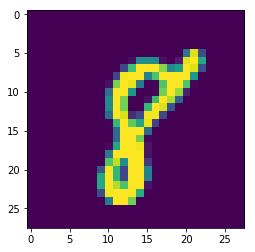

In [7]:
%matplotlib inline
for data, target in test_loader:
    break
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(data[0, 0, :, :])

(20, 1, 82, 82)


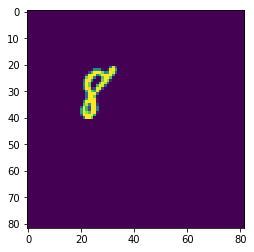

In [8]:
import numpy as np
data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 2, N_pix*3 - 2))
print(data_translate.shape)
data_translate[:, :, (N_pix-i_shift):(2*N_pix-i_shift), (N_pix-j_shift):(2*N_pix-j_shift)] = data
fig, ax = plt.subplots()
ax.imshow(data_translate[0, 0, :, :])

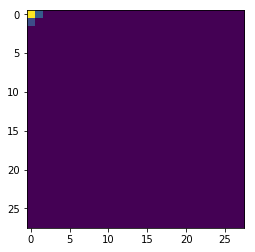

In [9]:
data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

In [10]:
np.arange(-N_pix+1, N_pix)

array([-27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15,
       -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,
        -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27])

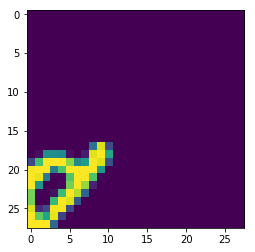

In [11]:
def shift_data(data, i_shift, j_shift):
    N_pix = data.shape[-1]
    assert(N_pix == data.shape[-2])
    import numpy as np
    data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 1, N_pix*3 - 1))
    data_translate[:, :, (N_pix+i_shift):(2*N_pix+i_shift), (N_pix+j_shift):(2*N_pix+j_shift)] = data
    data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
    return data_cropped

data_cropped = shift_data(data, i_shift = 12, j_shift = -12)
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

## Using the learned classifier on the shifted data

On peut maintenant tester le classifieur sur les images Translatées en calculant la valeur de classification en  fonction de l'erreur de localisation

In [12]:
def test_shift(test_loader, i_shift, j_shift, verbose=0):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data_cropped = shift_data(data, i_shift=i_shift, j_shift=j_shift)        
        data_cropped = torch.FloatTensor(data_cropped) #transforms.ToTensor()(data_cropped)
        data_cropped, target = Variable(data_cropped, volatile=True), Variable(target)
        output = model(data_cropped)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    if verbose: print('\nTest set: at ({}, {}), the  average loss is {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        i_shift, j_shift, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


path = "MNIST_accuracy.npy"

import os
if os.path.isfile(path):
    print('Loading accuracy')
    accuracy = np.load(path)
else:
    print('Computing accuracy')
    import time
    t0 = time.time()
    accuracy = np.zeros((2*N_pix-1, 2*N_pix-1))
    from tqdm import tqdm
    N_step = 1

    with tqdm(total=(2*N_pix-1)**2/N_step**2) as pbar:
        for i_shift in np.arange(-N_pix+1, N_pix, N_step):
            for j_shift in np.arange(-N_pix+1, N_pix, N_step):
                accuracy[i_shift+N_pix-1, j_shift+N_pix-1] = test_shift(test_loader, i_shift, j_shift)
                pbar.update()
    np.save(path, accuracy)
    print('Done in ', time.time() - t0, 'seconds')
    

Loading


J'avoue que c'est un peu bourrin de calculer la classification sur les 128 × 128 pixels pour 1000 batch multiplié par 10 type d'entrées.... Mais bon on doit faire ça seulement une fois :-) (et sur CPU une classif = environ 300µs ...)

In [21]:
help(plt.pcolor)


Help on function pcolor in module matplotlib.pyplot:

pcolor(*args, **kwargs)
    Create a pseudocolor plot of a 2-D array.
    
    Call signatures::
    
        pcolor(C, **kwargs)
        pcolor(X, Y, C, **kwargs)
    
    pcolor can be very slow for large arrays; consider
    using the similar but much faster
    :func:`~matplotlib.pyplot.pcolormesh` instead.
    
    Parameters
    ----------
    C : array_like
        An array of color values.
    
    X, Y : array_like, optional
        If given, specify the (x, y) coordinates of the colored
        quadrilaterals; the quadrilateral for ``C[i,j]`` has corners at::
    
            (X[i,   j],   Y[i,   j]),
            (X[i,   j+1], Y[i,   j+1]),
            (X[i+1, j],   Y[i+1, j]),
            (X[i+1, j+1], Y[i+1, j+1])
    
        Ideally the dimensions of ``X`` and ``Y`` should be one greater
        than those of ``C``; if the dimensions are the same, then the last
        row and column of ``C`` will be ignored.
    
    

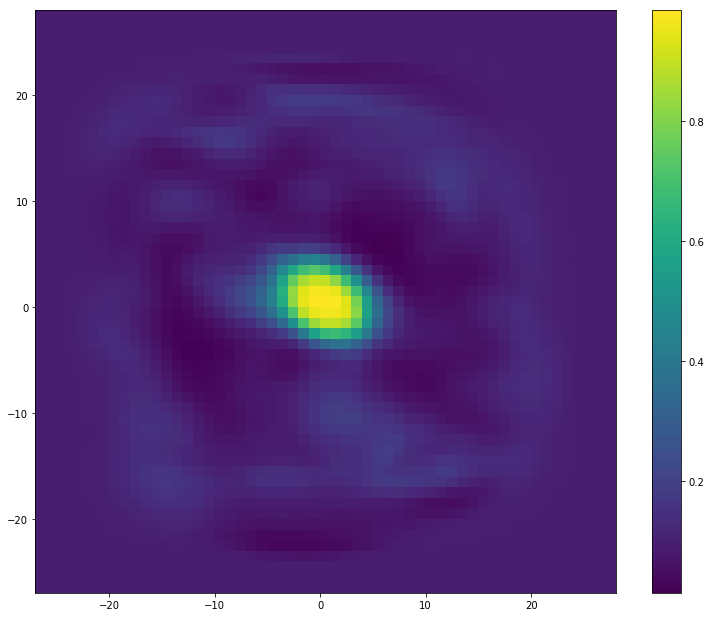

In [30]:
fig, ax = plt.subplots(figsize=(13, 10.725))
cmap = ax.pcolor(np.arange(-N_pix+1, N_pix+1), np.arange(-N_pix+1, N_pix+1), accuracy)
ax.axis('equal')
fig.colorbar(cmap)

In [14]:
accuracy

array([[0.0974, 0.0974, 0.0974, ..., 0.0974, 0.0974, 0.0974],
       [0.0974, 0.0974, 0.0974, ..., 0.0974, 0.0974, 0.0974],
       [0.0974, 0.0974, 0.0974, ..., 0.0974, 0.0974, 0.0974],
       ...,
       [0.0974, 0.0974, 0.0974, ..., 0.0974, 0.0974, 0.0974],
       [0.0974, 0.0974, 0.0974, ..., 0.0974, 0.0974, 0.0974],
       [0.0974, 0.0974, 0.0974, ..., 0.0974, 0.0974, 0.0974]])

Cette fonction de performance du classifieur  est calculée indépendamment de la forme spécifique du chiffre entre 0 et 9. Elle donne donc la carte de performance qu'on attend Au niveau de la classification/ On va pouvoir maintenant l'utiliser ceomm label pour apprendre de façon supervisée la correspondance entre la carte log-polaire obtenue depuis l'image brute et cette carte de performance.

In [15]:
!git s
!git add MNIST_accuracy.npy
!git commit -am' classifying on MNIST : accuracy'

 M 2018-02-16_clasiffier.ipynb
?? ../LabBooks/debug.log
?? .ipynb_checkpoints/
?? MNIST_data/
?? debug.log
[master b5cf701]  classifying on MNIST : accuracy
 1 file changed, 572 insertions(+), 877 deletions(-)
 rewrite Notebooks/2018-02-16_clasiffier.ipynb (71%)


In [16]:
!git pull

Already up to date.


In [17]:
!git push

Counting objects: 4, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 695 bytes | 695.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/pierrealbiges/ActiveVision
   76106a8..b5cf701  master -> master
